# Fit with Hurwitz zeta function
We fit the T_max vs nv using the zeta function Hurwitz model to obtain the critical temperature extrapolated.

In [3]:
%pylab inline

from pathlib import Path

import h5py
import numpy as np
from src.isingchat import style
from src.isingchat.io import read_ising_config
from matplotlib import pyplot, rcParams
from matplotlib.axes import Axes, GridSpec
from matplotlib.figure import Figure
from ruamel.yaml import YAML
from scipy import interpolate as interp
# from scipy.optimize import curve_fit
from scipy.optimize import least_squares, differential_evolution, minimize
from scipy.signal import savgol_filter
import pandas as pd
import json

import os
import re

yaml = YAML()

Populating the interactive namespace from numpy and matplotlib


## Model
El modelo a utilizar es:
$$ \frac{J}{k_BT} = a_1 \left(\frac{1}{series(n_v,p,z=1,a=a_2)}\right)$$ 
con
$$ series(n_v,p,z,a) = \sum_{i=0}^{n_v-1} \frac{z^i}{(i+a)^p}  $$ 

In [4]:
def serie_divergente(n: int,p: float, z: float=1, a: float=1):
    res = 0
    for i in np.arange(0,n,1):
        res = res + z**i/((i+a)**p)
    return res


def model_function(x: float,coefs):
    """x = 1/nv"""
    a1,a2 = coefs
    return a1*(1/serie_divergente(1/x,p,z=1,a=a2))


def get_extrapol_function(model_function, coefs):
    def extrapol_funct(x):
        return model_function(x, coefs)
    return extrapol_funct

In [17]:
def residuals_func(coefs,x,fi,fi_err=None,rescale_incert=100):
    """Calculate the residuals for the least squares minimization routine.
    
    This function returns a value with the difference between the expected value
    of the model, which we set to zero for all x and y, and the predictions of the
    model.
    Args:
        coefs: Tuple: Parameters to be adjusted of the model
        x: float: Independent variable
        fi: float: Experimental value to adjust, also call y_i
        fi_err: Error for the experimental value, also call y_err_i
    Returns:
        residuals: float: Difference of the model evaluation and expected value
    """
    # We want the model to be almost zero, i.e., that the coefficients and data
    # satisfy the conic equation.
    if fi_err is not None:
        residuals = (fi - model_function(
            x,
            coefs
        )) / (fi_err*rescale_incert)
        
        return residuals
    else:
        residuals = fi - model_function(
            x,
            coefs
        )
        
        return residuals


def get_residuals_func_sum_sqr(x_data,y_data,y_data_err=None,rescale_err=100):
    def residuals_func_sum_sqr(coefs):
        """Calculate the sum of the squared residuals."""
        result = 0
        num_el = len(x_data)
        for index in range(num_el):
            if y_data_err is not None:
                result = result + residuals_func(coefs,x_data[index],y_data[index],y_data_err[index],rescale_err)**2
            else:
                result = result + residuals_func(coefs,x_data[index],y_data[index])**2
        return result

    return residuals_func_sum_sqr

## Read files

In [83]:
ratio = 2
# get inv_temp
data_path = os.path.join(os.environ["VIRTUAl_ENV"],
    Path("data/imperfect/infinite-size/unitcell_2/ratio_{}".format(ratio)).resolve())
file_path = os.path.join(data_path,'unitcell-2_ratio-{}_all_inv_Tmax.csv'.format(ratio))
df_all_tc = pd.read_csv(file_path)
# get uncert inv_temp
file_err = os.path.join(data_path,'unitcell-2_ratio-{}_all_inv_Tmax_uncertainty.csv'.format(ratio))
df_all_tc_err = pd.read_csv(file_err)

In [84]:
df_params = pd.DataFrame(index=["a1","a2","a1_err","a2_err"])
df_extrapol_val = pd.DataFrame(index=["infty","1"])

------------------
p = 1.0
------------------
rescale_incert: 1493.405335293742
      fun: 0.0009844136880650155
 hess_inv: array([[  67.47890263, -212.90780339],
       [-212.90780339,  674.77365814]])
      jac: array([-1.60915079e-06, -4.81188181e-07])
  message: 'Optimization terminated successfully.'
     nfev: 57
      nit: 16
     njev: 19
   status: 0
  success: True
        x: array([0.82434105, 1.52911778])


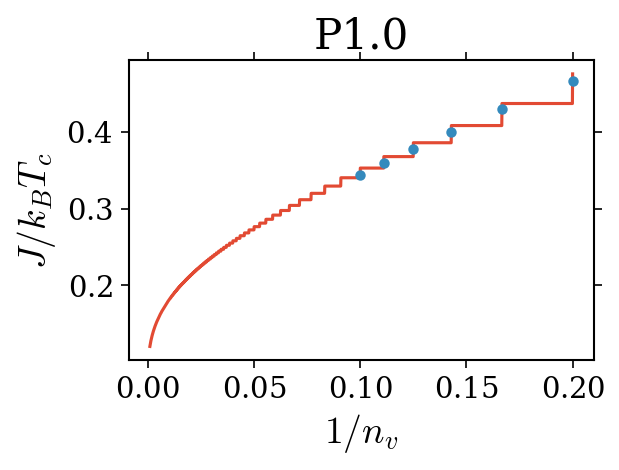

---------------------------------------------
coefs:[0.82434105 1.52911778]
---------------------------------------------
min:0.12042227180727998 at 0.001
fit at 1/nv=1: 1.260514564954264


hess_inv: [  67.47890263 -212.90780339]
hess_inv: [-212.90780339  674.77365814]
Uncertainty: [0.25773466084426805, 0.8150192791673582]
------------------
p = 1.1
------------------
rescale_incert: 1206.4484977220934
      fun: 0.0009054234971776077
 hess_inv: array([[ 0.39190048, -0.27275209],
       [-0.27275209,  0.87817897]])
      jac: array([ 6.08779374e-08, -2.05458491e-07])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([0.85095341, 1.43377576])


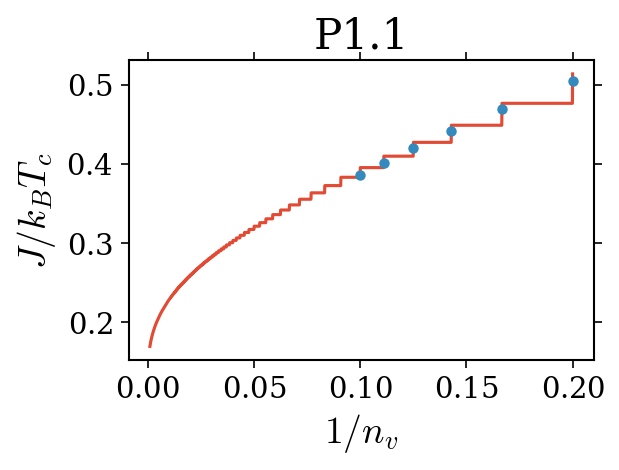

---------------------------------------------
coefs:[0.85095341 1.43377576]
---------------------------------------------
min:0.1697760045539893 at 0.001
fit at 1/nv=1: 1.264838675488596


hess_inv: [ 0.39190048 -0.27275209]
hess_inv: [-0.27275209  0.87817897]
Uncertainty: [0.018837088417569037, 0.02819794093235393]
------------------
p = 1.5
------------------
rescale_incert: 590.1968587633299
      fun: 0.0004993880966930494
 hess_inv: array([[ 170.12987001, -181.05106682],
       [-181.05106682,  192.99733841]])
      jac: array([8.98654253e-06, 9.21875471e-06])
  message: 'Optimization terminated successfully.'
     nfev: 78
      nit: 18
     njev: 26
   status: 0
  success: True
        x: array([1.03745075, 1.12344177])


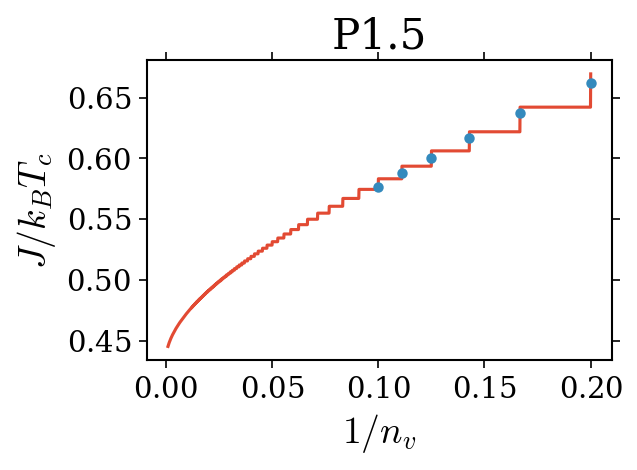

---------------------------------------------
coefs:[1.03745075 1.12344177]
---------------------------------------------
min:0.4454251367620761 at 0.001
fit at 1/nv=1: 1.2353594353092903


hess_inv: [ 170.12987001 -181.05106682]
hess_inv: [-181.05106682  192.99733841]
Uncertainty: [0.29148041439354083, 0.3104522080713761]
------------------
p = 1.9
------------------
rescale_incert: 353.89490524728427
      fun: 0.00010329726076493383
 hess_inv: array([[1136.52948958, -454.02475593],
       [-454.02475593,  181.42043976]])
      jac: array([-7.00791134e-07, -1.73837088e-06])
  message: 'Optimization terminated successfully.'
     nfev: 168
      nit: 41
     njev: 56
   status: 0
  success: True
        x: array([1.48545631, 0.88260635])


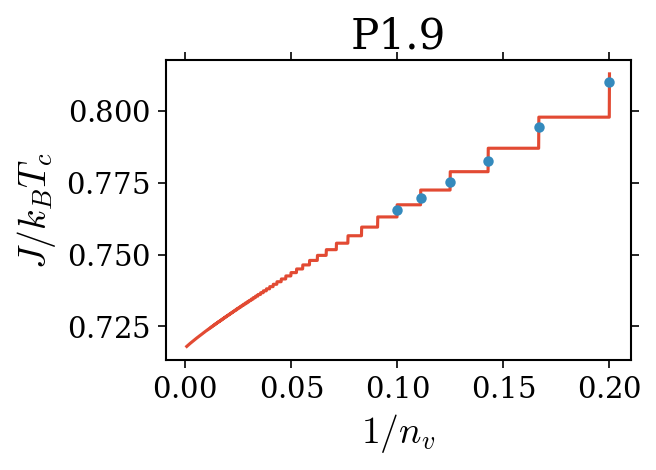

---------------------------------------------
coefs:[1.48545631 0.88260635]
---------------------------------------------
min:0.7180543680847101 at 0.001
fit at 1/nv=1: 1.171702279283603


hess_inv: [1136.52948958 -454.02475593]
hess_inv: [-454.02475593  181.42043976]
Uncertainty: [0.3426373929571875, 0.13689497607188178]
------------------
p = 2.0
------------------
rescale_incert: 320.5628330436833
      fun: 6.263237813152928e-05
 hess_inv: array([[2265.50676203, -682.08683901],
       [-682.08683901,  205.39126939]])
      jac: array([-6.14063538e-08, -2.10293365e-07])
  message: 'Optimization terminated successfully.'
     nfev: 168
      nit: 49
     njev: 56
   status: 0
  success: True
        x: array([1.69363374, 0.82536413])


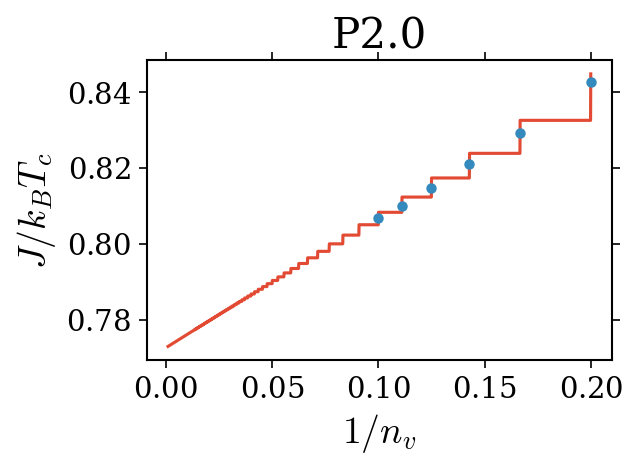

---------------------------------------------
coefs:[1.69363374 0.82536413]
---------------------------------------------
min:0.7730461262580615 at 0.001
fit at 1/nv=1: 1.1537472537389437


hess_inv: [2265.50676203 -682.08683901]
hess_inv: [-682.08683901  205.39126939]
Uncertainty: [0.3766883010915301, 0.11342020829434085]


In [85]:
epsilon = 0.0001
tol = 2.220446049250313e-09 # tolerance by minimize 
chi_squared = False
min_nv = 5
if min_nv == 1:
    nv_ind = 0
else:
    nv_ind = min_nv-2
# COLUMNS = ["P1.0","P1.05","P1.1","P1.2","P1.3","P1.4","P1.5","P1.6","P1.7","P1.8","P1.9","P2.0"]
COLUMNS = ["P1.0","P1.1","P1.5","P1.9","P2.0"]
path_save_graph = Path("../../graphs/").resolve()
file_name_base = 'inv_Tc_vs_inv_nv_extrapol_hurwitz_2_parms_with_nv_{}plus_and_error_v30nv'.format(min_nv)
if chi_squared is True:
    file_name_base += "_chi-squared"
for COLUMN in COLUMNS:
    p = float(COLUMN.replace("P",""))
    print("------------------")
    print("p = {}".format(p))
    print("------------------")
    file_graph = file_name_base + '_{}.png'.format(COLUMN)
    # Get the data in arrays
    df_part = df_all_tc[["1/nv",COLUMN]][nv_ind:]
    df_part = df_part.dropna()
    x_data = df_part['1/nv'].values
    y_data = df_part[COLUMN].values
    y_data_err = df_all_tc_err[COLUMN].dropna()[nv_ind:].values

    if min_nv == 1:
        # add value at nv=1
        x_data = np.concatenate([x_data,[1]])
        y_data = np.concatenate([y_data,[1.19968]])
        if COLUMN == 'P1.0':
            #add value at nv=infty
            x_data = np.insert(x_data,0,0)
            y_data = np.insert(y_data,0,0)
    
    # rescale
    rescale_incert = 1/y_data_err[3]
    print('rescale_incert: {}'.format(rescale_incert))
        
    # fit 
    if chi_squared is True:
        funct_to_min = get_residuals_func_sum_sqr(x_data,y_data,y_data_err,rescale_incert)
    else:
        funct_to_min = get_residuals_func_sum_sqr(x_data,y_data)
#     funct_to_min = get_residuals_func_sum_sqr(x_data,y_data,y_data_err,rescale_incert)
#     funct_to_min = get_residuals_func_sum_sqr(x_data,y_data)
    best_fit_result = minimize(funct_to_min,
                               x0=(1,1.5),
#                                method = 'Nelder-Mead',
                               options={'maxiter':100},
#                                tol=tol
                              )
    print(best_fit_result)

    extrapol_funct = get_extrapol_function(model_function, best_fit_result.x)
    
    # define the point for graph
    x_extrapol = np.linspace(0.001, 1/(min_nv), 2048)
    y_extrapol = []
    for x_ext in x_extrapol:
        y_extrapol.append(extrapol_funct(x_ext))

    # Load the default style.
    style.use("default")
    rcParams["text.usetex"] = False

    fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
    grid_spec = GridSpec(3, 1)

    # Specific heat subplot.
    ax: Axes = fig1.add_subplot(grid_spec[0, 0])

    ax.plot(x_extrapol, y_extrapol, lw=1.5)
    ax.plot(x_data, y_data, marker="o", lw=0)

    ax.set_xlabel(r"$1/n_v$")
    ax.set_ylabel(r"$J/k_BT_c$")
    # add text
#     ax.text(0.1, 0.2, r"$ \frac{J}{k_BT} = a_1 \left(\frac{1}{series(n_v,p,z=1,a=a_2)}\right)$",
#            fontsize=8)

    ax.set_title(COLUMN)
    pyplot.draw()
#     print('Save graph {}'.format(os.path.join(path_save_graph,file_graph)))
#     pyplot.savefig(os.path.join(path_save_graph,file_graph))
    pyplot.show()
    print("---------------------------------------------")
    print("coefs:{}".format(best_fit_result.x))
    print("---------------------------------------------")
    print("min:{} at {}".format(np.nanmin(y_extrapol),x_extrapol[np.nanargmin(y_extrapol)]))
    print("fit at 1/nv=1: {}".format(extrapol_funct(1)))
    print("\n")
    
    # For errors
    uncertainty = []
    tmp_i = np.zeros(len(best_fit_result.x))
    for i in range(len(best_fit_result.x)):
        tmp_i[i] = 1.0
        hess_inv = np.dot(best_fit_result.hess_inv,tmp_i)
#         hess_inv = np.dot(best_fit_result.final_simplex[0],tmp_i)
        print('hess_inv: {}'.format(hess_inv))
#         uncertainty.append(np.sqrt(max(1, abs(best_fit_result.fun)) * tol * hess_inv[i]))
        uncertainty.append(np.sqrt(best_fit_result.fun * hess_inv[i]))
#         uncertainty.append(np.sqrt(hess_inv[i]))
        tmp_i[i] = 0
    print('Uncertainty: {}'.format(uncertainty))
        
    df_params[COLUMN] = [*best_fit_result.x,*uncertainty]

## Extrapol values

In [86]:
def get_extrapol_err(coefs: object,p: float):
    params = [coefs["a1"],coefs["a2"]]
    params_err = [coefs["a1_err"],coefs["a2_err"]]
    all_eval_params = [[params[0]+params_err[0],params[1]+params_err[1]],
                       [params[0]+params_err[0],params[1]-params_err[1]],
                       [params[0]-params_err[0],params[1]+params_err[1]],
                       [params[0]-params_err[0],params[1]-params_err[1]],
                      ]
    all_err_extrapol = []
    for eval_par in all_eval_params:
        all_err_extrapol.append(abs(coefs['a1']*(1/zeta(p,coefs['a2'])) - eval_par[0]*(1/zeta(p,eval_par[1]))))
    return max(all_err_extrapol)

In [87]:
from scipy.special import zeta
# COLUMNS = ["P1.0","P1.05","P1.1","P1.2","P1.3","P1.4","P1.5","P1.6","P1.7","P1.8","P1.9",
#            "P2.0"]
COLUMNS = ["P1.0","P1.1","P1.5","P1.9","P2.0"]
for COLUMN in COLUMNS:
    p = float(COLUMN.replace("P",""))
    df_extrapol_val[COLUMN]=[df_params[COLUMN]['a1']*(1/zeta(p,df_params[COLUMN]['a2'])),get_extrapol_err(df_params[COLUMN],p)]

## Save params

In [88]:
df_params

,P1.0,P1.1,P1.5,P1.9,P2.0
a1,0.824341,0.850953,1.037451,1.485456,1.693634
a2,1.529118,1.433776,1.123442,0.882606,0.825364
a1_err,0.257735,0.018837,0.291480,0.342637,0.376688
a2_err,0.815019,0.028198,0.310452,0.136895,0.113420


In [89]:
df_extrapol_val

,P1.0,P1.1,P1.5,P1.9,P2.0
infty,0.0,0.084895,0.433653,0.717286,0.772694
1,0.0,0.002118,0.227744,0.354570,0.374109


In [90]:
file_name_base

'inv_Tc_vs_inv_nv_extrapol_hurwitz_2_parms_with_nv_5plus_and_error_v30nv'

In [91]:
data_path
if not os.path.isdir(os.path.join(data_path,'Extrapolation')):
    print("making folder: {}".format(os.path.join(data_path,'Extrapolation')))
    os.mkdir(os.path.join(data_path,'Extrapolation'))
print(data_path)

making folder: C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\isingchat\data\imperfect\infinite-size\unitcell_2\ratio_2\Extrapolation
C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\isingchat\data\imperfect\infinite-size\unitcell_2\ratio_2


In [92]:
# Define tha path and name for the csv files
file_params = os.path.join(data_path,'Extrapolation',file_name_base+'_params_curves.csv')
file_extrapol_values = os.path.join(data_path,'Extrapolation',file_name_base+'_extrapol_values.csv')
print(df_params)
print("Exporting to csv files the params adjusted {}".format(file_params))
df_params.to_csv(file_params)
print(df_extrapol_val)
print("Exporting to csv files the extrapolation values adjusted {}".format(file_extrapol_values))
df_extrapol_val.to_csv(file_extrapol_values)

            P1.0      P1.1      P1.5      P1.9      P2.0
a1      0.824341  0.850953  1.037451  1.485456  1.693634
a2      1.529118  1.433776  1.123442  0.882606  0.825364
a1_err  0.257735  0.018837  0.291480  0.342637  0.376688
a2_err  0.815019  0.028198  0.310452  0.136895  0.113420
Exporting to csv files the params adjusted C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\isingchat\data\imperfect\infinite-size\unitcell_2\ratio_2\Extrapolation\inv_Tc_vs_inv_nv_extrapol_hurwitz_2_parms_with_nv_5plus_and_error_v30nv_params_curves.csv
       P1.0      P1.1      P1.5      P1.9      P2.0
infty   0.0  0.084895  0.433653  0.717286  0.772694
1       0.0  0.002118  0.227744  0.354570  0.374109
Exporting to csv files the extrapolation values adjusted C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\isingchat\data\imperfect\infinite-size\unitcell_2\ratio_2\Extrapolation\inv_Tc_vs_inv_nv_extrapol_hurwitz_2_parms_with_nv_5plus_and_error_v30nv_extrapol_values.csv
